In [ ]:
%matplotlib inline

In [8]:
from lifelines import KaplanMeierFitter
import pandas
import aql
conn = aql.Connection("http://arachne.compbio.ohsu.edu")
O = conn.graph("bmeg")

In [14]:
q = O.query().V().where(aql.eq("$.label", "Individual"))
#q = q.where(aql.and_(aql.eq("source", "tcga"), aql.eq("disease_code", "KIRC")))
q = q.where(aql.and_(aql.eq("source", "tcga"), aql.eq("vital_status", "Dead")))

days = []
for row in q:
    #for k in row['vertex']['data']:
    #    if 'day' in k:
    #        a.add( k )
    status = row['vertex']['data'].get('vital_status', None)
    last = row['vertex']['data'].get('last_contact_days_to', None)
    initial = row['vertex']['data'].get('initial_pathologic_dx_days_to', None)
    death = row['vertex']['data'].get('death_days_to', None)
    alive = row['vertex']['data'].get('days_to_last_known_alive', None)
    if status == "Dead":
        #print status, initial, last, int(death), alive
        days.append(int(death))
    #print row['vertex']['data']

Dead 0 None 571 None
Dead 0 None 1111 None
Dead 0 None 106 None
Dead 0 None 1337 None
Dead 0 None 1625 None
Dead 0 None 727 None
Dead 0 None 182 None
Dead 0 None 2343 None
Dead 0 None 1912 None
Dead 0 None 480 None
Dead 0 None 1598 None
Dead 0 None 1034 None
Dead 0 None 2752 None
Dead 0 None 77 None
Dead 0 None 204 None
Dead 0 None 41 None
Dead 0 None 62 None
Dead 0 None 793 None
Dead 0 None 552 None
Dead 0 None 1371 None
Dead 0 59 59 45
Dead 0 841 841 822
Dead 0 None 1404 None
Dead 0 None 1913 None
Dead 0 None 1191 None
Dead 0 None 2830 None
Dead 0 None 329 None
Dead 0 None 1584 None
Dead 0 None 578 None
Dead 0 None 1121 None
Dead 0 None 485 None
Dead 0 None 168 None
Dead 0 None 1590 None
Dead 0 None 822 None
Dead 0 None 51 None
Dead 0 None 375 None
Dead 0 None 344 None
Dead 0 None 1097 None
Dead 0 None 99 None
Dead 0 None 646 None
Dead 0 None 137 None
Dead 0 None 166 None
Dead 0 None 1734 None
Dead 0 None 963 None
Dead 0 None 1023 None
Dead 0 None 1019 None
Dead 0 None 1597 None
Dead

TypeError: int() argument must be a string or a number, not 'NoneType'

In [17]:
len(days)

148

In [4]:
kmf = KaplanMeierFitter()
kmf.fit(days)
kmf.plot()


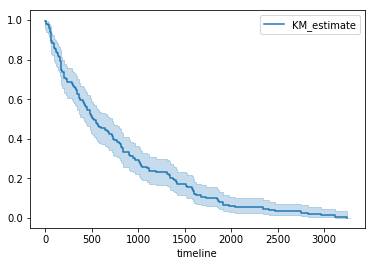

In [19]:
q = O.query().V().where(aql.eq("$.label", "Individual"))
#q = q.where(aql.and_(aql.eq("source", "tcga"), aql.eq("disease_code", "KIRC")))
#q = q.where(aql.and_(aql.eq("source", "tcga"), aql.eq("vital_status", "Dead")))
q = q.where(aql.and_(aql.eq("source", "tcga")))
len(list(q))

6420